# Semi Final Codes Notebook

## Intro

The purpose of this notebook is to keep the necessary blocks and codes that we are going to use in our final model.
It will help us to keep track of every finished part of the project and helps with debugging of each section as we are ready to implement them.  

## Importing necessary libraries

In [1]:
# Libraries to install

# %pip install librosa
# %pip install matplotlib==3.3.4
# %pip install datasets[audio]

In [2]:
import os, sys

import numpy as np
import pandas as pd

import torch
torch.manual_seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import librosa

import Lib  # the project's own library of functions

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Initializing Datasets

Note: Make sure you have downloaded the datasets and placed them in the './Data/' directory

each of these blocks pre-process their respective dataset. For each available dataset, run it's corresponding block to make sure its ready to be utilized.

In [4]:
CREMA = Lib.CREMA()

Dataset has already been normalized and resampled. Skipping...


In [5]:
# RAVDESS = Lib.RAVDESS()

In [6]:
SAVEE = Lib.SAVEE()

Dataset has already been normalized and resampled. Skipping...


In [7]:
TESS = Lib.TESS()

Dataset has already been normalized and resampled. Skipping...


## Prepare the Data

In [8]:
def pad_audio(audio, sr, desired_length_in_sec):

    # desired_length is desired length of audio in seconds
    # audio is the raw audio signal as numpy array from librosa
    # sr is sampling rate
    desired_length = int(sr * desired_length_in_sec)

    # Truncate if too long
    if len(audio) > desired_length:
        audio = audio[:desired_length]
        # TODO: Check for silent parts before cropping the audio file

    # Else, pad with 0s
    else:
        padding = int(desired_length - len(audio))
        audio = np.pad(audio, (0, padding), 'constant')
    return audio

In [9]:
# extract MFCCs from the audio files
def extract_mfccs(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    audio = pad_audio(audio, sr, 2.0)

    # This returns an mfcc where the COLUMNS correspond to the frames of the audio,
    # and ROWS represent features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # This extracts info about the first and second derivative of the mfcc
    # so we can get an idea of how the audio changes over time
    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Stacking mfcc and deltas together
    combined_matrix = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    # print("MFCC shape:", mfcc.shape)
    # print("Delta MFCC shape:", delta_mfcc.shape)
    # print("Delta2 MFCC shape:", delta2_mfcc.shape)

    # Normalize mfccs
    combined_matrix = (combined_matrix - np.mean(combined_matrix, axis=0)) / np.std(combined_matrix, axis=0)
    # print("Combined matrix shape before transpose:", combined_matrix.shape)

    # We transpose so that the ROWS correspond to the frames of the audio, 
    # while COLUMNS represent features
    transposed_matrix = np.transpose(combined_matrix, [1, 0])
    # print("Transposed matrix shape:", transposed_matrix.shape)

    # Display the combined matrix
    # It has been commented to reduce clutter during debug
    '''
    plt.figure(figsize=(12, 6))
    # plt.imshow(combined_matrix, aspect='auto', origin='lower', cmap='viridis')

    # We divide the y-axis into three equal parts to denote MFCC, delta, and delta-delta regions
    num_rows = combined_matrix.shape[0]
    plt.yticks(
        [num_rows/6, num_rows/2, 5*num_rows/6],
        ['MFCC', 'Delta', 'Delta-Delta']
    )

    plt.title('Combined MFCC, Delta, Delta-Delta Coefficients')
    plt.xlabel('Frame')
    plt.ylabel('Coefficients')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    '''
    return transposed_matrix

In [27]:
class ResampledAudioDataset(Dataset):
    
    def __init__(self, *datasets):
        # 'audio_files' is a dictionary that will contain path and labels for every audio file in the given datasets
        # and is formatted as {'path': [], 'label': []}
        self.audio_files = Lib.merge_dataset_dictionaries(*datasets)
        print(pd.DataFrame(self.audio_files))

    def __len__(self):
        return len(self.audio_files['path'])
    
    def __getitem__(self, index):
        audio_path = self.audio_files['path'][index]
        audio_label = self.audio_files['label'][index]
        audio_file = extract_mfccs(audio_path)

        # Prints the the requested audio file details
        # It has been commented to reduce clutter during debug
        '''
        print('----------- Audio file Data -----------')
        print('Audio path:', audio_path)
        print ('Audio label:', audio_label, f'({Lib.convert_label(audio_label)})')
        '''
        return audio_file, audio_label

In [11]:
# creating the dataset from all available audio files for the model
# TODO: Add RAVDESS
audio_dataset = ResampledAudioDataset(CREMA, TESS, SAVEE)

train_len = int(len(audio_dataset) * 0.8)   # 80% of the data will be used for the training
test_len = len(audio_dataset) - train_len   # 20% of the data will be used for the testing
train_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [train_len, test_len])

b_size = 32 # batch size
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

                                                    path  label
0      Data\resampled\CREMA\CREMA_resampled_0_emotion...      4
1      Data\resampled\CREMA\CREMA_resampled_1_emotion...      6
2      Data\resampled\CREMA\CREMA_resampled_2_emotion...      5
3      Data\resampled\CREMA\CREMA_resampled_3_emotion...      2
4      Data\resampled\CREMA\CREMA_resampled_4_emotion...      0
...                                                  ...    ...
10717  Data\resampled\SAVEE\SAVEE_resampled_475_emoti...      7
10718  Data\resampled\SAVEE\SAVEE_resampled_476_emoti...      7
10719  Data\resampled\SAVEE\SAVEE_resampled_477_emoti...      7
10720  Data\resampled\SAVEE\SAVEE_resampled_478_emoti...      7
10721  Data\resampled\SAVEE\SAVEE_resampled_479_emoti...      7

[10722 rows x 2 columns]


### ----------------- Temp Test Block -----------------

In [12]:
train_dataset[1]

(array([[-3.7319832 ,  4.5732923 ,  0.3336608 , ..., -0.09736449,
         -0.05904803, -0.09416623],
        [-3.0725203 ,  4.9015636 , -0.09429274, ..., -0.11522528,
         -0.0782264 , -0.112137  ],
        [-3.137642  ,  4.839657  , -0.27211338, ..., -0.11588274,
         -0.07950663, -0.11284645],
        ...,
        [-3.168401  ,  4.728629  , -0.16814974, ..., -0.11345246,
         -0.10112239, -0.11046126],
        [-3.3089724 ,  4.625251  , -0.1930185 , ..., -0.09074324,
         -0.07834204, -0.08773477],
        [-3.6005087 ,  4.5279417 , -0.13044648, ..., -0.07331912,
         -0.06122997, -0.07038637]], dtype=float32),
 3)

# Build the model

In [13]:
class CNNModel(nn.Module): # 94 by 39 matrix sizes
  def __init__(self, num_classes):
    super().__init__()
    self.model = nn.Sequential(
      # torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
      # stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        
        # what we had before
        nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Flatten(),

        nn.Linear(13248, 256),
        nn.ReLU(),

        nn.Linear(256, 128),
        nn.ReLU(),

        nn.Linear(128, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.model(x)
    return x

model = CNNModel(num_classes=8).to(device)

In [14]:
model

CNNModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=13248, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=8, bias=True)
    (14): Softmax(dim=1)
  )
)

# Train the model

In [20]:
def save_checkpoint(lr, fold, epoch, model, optimizer, filepath):
  checkpoint = {
      'lr': lr,
      'fold': fold,
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }
  torch.save(checkpoint, filepath)

In [21]:
# learning rates
lr_values = [0.0005, 0.001, 0.005, 0.01]

In [25]:
def grid_search(num_epochs, lr_values):
  print("running grid")
  criterion = nn.CrossEntropyLoss()
  all_loss_history = {}
  all_train_accuracy_history = {}
  all_val_accuracy_history = {}

  # Number of folds and batch size
  k_folds = 10
  batch_size = 32 

  for learn_rate in lr_values:
    print(f"-----LEARNING RATE: {learn_rate}-----")
    
    kf = KFold(n_splits=k_folds, shuffle=True)

    # Loop through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):      # the training dataset; includes validation
      print(f"Fold {fold + 1}")
      print("-------")

      # Train/validation data loaders for current fold
      train_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(train_idx),
      )
      val_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          sampler=torch.utils.data.SubsetRandomSampler(val_idx),
        )

      optimizer = optim.Adam(model.parameters(), lr=learn_rate)
      loss_history, train_accuracy_history, val_accuracy_history = train(num_epochs, learn_rate, fold, optimizer, criterion, train_loader, val_loader)
      try:
        all_loss_history[learn_rate].append(loss_history)
        all_train_accuracy_history[learn_rate].append(train_accuracy_history)
        all_val_accuracy_history[learn_rate].append(val_accuracy_history)
      except:
        all_loss_history[learn_rate] = [loss_history]
        all_train_accuracy_history[learn_rate] = [train_accuracy_history]
        all_val_accuracy_history[learn_rate] = [val_accuracy_history]

  return all_loss_history, all_train_accuracy_history, all_val_accuracy_history


def train(num_epochs, lr, fold, optimizer, criterion, train_loader, val_loader):
  print("running")
  # For plotting after training
  loss_history = []
  train_accuracy_history = []
  val_accuracy_history = []

  for epoch in range(num_epochs):
    model.train()

    # Evaluating accuracy
    running_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_loader:
      # Start train
      inputs = inputs.unsqueeze(1)
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # End train

      total_correct_train += (predicted == labels).sum().item()
      total_samples_train += labels.size(0)

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    accuracy_train = total_correct_train / total_samples_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%')

    loss_history.append(epoch_loss)
    train_accuracy_history.append(accuracy_train)

    save_checkpoint(lr, fold, epoch, model, optimizer, f'./Checkpoints/checkpoint_lr_{lr}_fold_{fold}_epoch_{epoch}.pth')

    model.eval()
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
      for images, labels in val_loader:
        images = images.unsqueeze(1)             # add this line here
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_correct_val += (predicted == labels).sum().item()
        total_samples_val += labels.size(0)

    accuracy_val = total_correct_val / total_samples_val
    print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")
    val_accuracy_history.append(accuracy_val)

  return loss_history, train_accuracy_history, val_accuracy_history

In [ ]:
loss, train_acc, val_acc = grid_search(num_epochs=25, lr_values=[0.001]) # Change later

In [ ]:
def load_checkpoint(model, optimizer, filepath):
  checkpoint = torch.load(filepath)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  
  # lr = checkpoint['lr']
  # fold = checkpoint['fold']

  return model, optimizer, epoch

check_epoch = 15
check_fold = 5
loaded_model, loaded_optimizer, start_epoch = load_checkpoint(model, optimizer, f'./Checkpoints/checkpoint_epoch_{check_epoch}.pth')

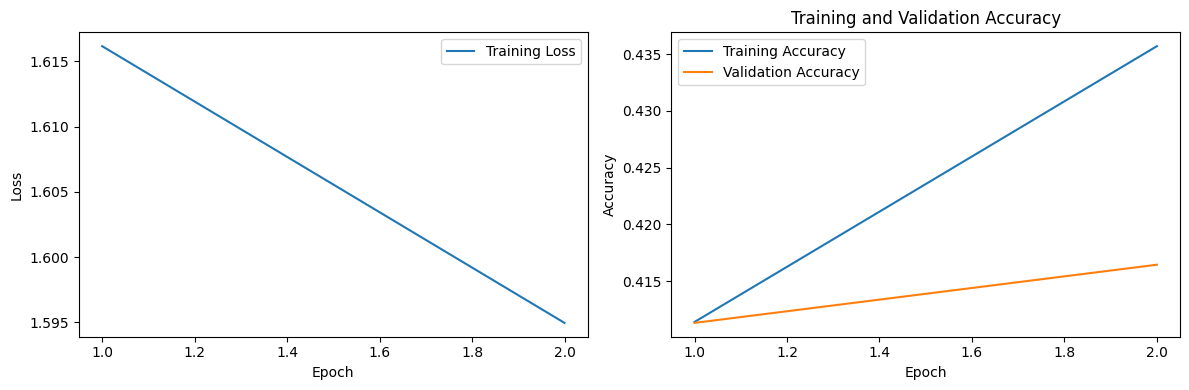

In [ ]:
# to edit


epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Saving the Weights

Block to save the trained weights:
- TODO: (We need to define "model")

In [ ]:
torch.save(model.state_dict(), './ModelWeights/trained_model.pth')

Load the trained weights:

In [ ]:
model = CNNModel(num_classes=6).to(device)
model.load_state_dict(torch.load('./ModelWeights/trained_weights.pth'))
model.eval()